# Boosting a decision stump

The goal of this notebook is to implement your own boosting module.

**Brace yourselves**! This is going to be a fun and challenging assignment.


* Use Pandas to do some feature engineering.
* Modify the decision trees to incorporate weights.
* Implement Adaboost ensembling.
* Use your implementation of Adaboost to train a boosted decision stump ensemble.
* Evaluate the effect of boosting (adding more decision stumps) on performance of the model.
* Explore the robustness of Adaboost to overfitting.

Let's get started!

# Fire up Pandas and Numpy

In [58]:
import pandas as pd
import numpy as np

In [59]:
loans = pd.read_csv('lending-club-data.csv')

/Users/yunpeng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

In [61]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

### Extracting the target and the feature columns

We will now repeat some of the feature processing steps that we saw in the previous assignment:

First, we re-assign the target to have +1 as a safe (good) loan, and -1 as a risky (bad) loan.

Next, we select four categorical features: 
1. grade of the loan 
2. the length of the loan term
3. the home ownership status: own, mortgage, rent
4. number of years of employment.

In [62]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.drop('bad_loans',1)
target = 'safe_loans'
loans = loans[features + [target]]

In [63]:
loans.columns

Index(['grade', 'term', 'home_ownership', 'emp_length', 'safe_loans'], dtype='object')

In [64]:
loans=pd.get_dummies(loans)
loans.head()

,safe_loans,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,...,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
0,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,-1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [65]:
#read the index documents
train_idx = pd.read_json('module-8-assignment-2-train-idx.json')
test_idx = pd.read_json('module-8-assignment-2-test-idx.json')

In [66]:
#pull train and test data from temp_loans using the index docs
train_data = loans.iloc[train_idx.values.reshape((-1,))]
test_data = loans.iloc[test_idx.values.reshape((-1,))]

In [67]:
train_data.columns

Index(['safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year'],
      dtype='object')

In [68]:
features = loans.columns.tolist()
features.remove('safe_loans')  # Remove the response variable
features

['grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'term_ 36 months',
 'term_ 60 months',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year']

# Weighted decision trees

Let's modify our decision tree code from Module 5 to support weighting of individual data points.

### Weighted error definition

Consider a model with $N$ data points with:
* Predictions $\hat{y}_1 ... \hat{y}_n$ 
* Target $y_1 ... y_n$ 
* Data point weights $\alpha_1 ... \alpha_n$.

Then the **weighted error** is defined by:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i}
$$
where $1[y_i \neq \hat{y_i}]$ is an indicator function that is set to $1$ if $y_i \neq \hat{y_i}$.


### Write a function to compute weight of mistakes

Write a function that calculates the weight of mistakes for making the "weighted-majority" predictions for a dataset. The function accepts two inputs:
* `labels_in_node`: Targets $y_1 ... y_n$ 
* `data_weights`: Data point weights $\alpha_1 ... \alpha_n$

We are interested in computing the (total) weight of mistakes, i.e.
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}].
$$
This quantity is analogous to the number of mistakes, except that each mistake now carries different weight. It is related to the weighted error in the following way:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}
$$

The function **intermediate_node_weighted_mistakes** should first compute two weights: 
 * $\mathrm{WM}_{-1}$: weight of mistakes when all predictions are $\hat{y}_i = -1$ i.e $\mathrm{WM}(\mathbf{\alpha}, \mathbf{-1}$)
 * $\mathrm{WM}_{+1}$: weight of mistakes when all predictions are $\hat{y}_i = +1$ i.e $\mbox{WM}(\mathbf{\alpha}, \mathbf{+1}$)
 
 where $\mathbf{-1}$ and $\mathbf{+1}$ are vectors where all values are -1 and +1 respectively.
 
After computing $\mathrm{WM}_{-1}$ and $\mathrm{WM}_{+1}$, the function **intermediate_node_weighted_mistakes** should return the lower of the two weights of mistakes, along with the class associated with that weight. We have provided a skeleton for you with `YOUR CODE HERE` to be filled in several places.

In [69]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = np.sum(data_weights[labels_in_node == +1])
    #print('weights',total_weight_positive)
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    #print('number of mistakes',(labels_in_node == +1).sum())
    weighted_mistakes_all_negative = np.sum(total_weight_positive*1)
    #print('weighted_mistakes_all_negative',weighted_mistakes_all_negative)
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    total_weight_negative = np.sum(data_weights[labels_in_node == -1])
    #print('weights',total_weight_negative)
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    #print('number of mistakes',(labels_in_node == -1).sum())
    weighted_mistakes_all_positive = np.sum(total_weight_negative*1)
    #print('weighted_mistakes_all_positive',weighted_mistakes_all_positive)
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_negative >= weighted_mistakes_all_positive:
        (weight, class_label)=(weighted_mistakes_all_positive, +1)
        return (weight, class_label)
    elif weighted_mistakes_all_positive > weighted_mistakes_all_negative:
        (weight, class_label)=(weighted_mistakes_all_negative, -1)
        return (weight, class_label)
        
    

**Checkpoint:** Test your **intermediate_node_weighted_mistakes** function, run the following cell:

In [70]:
example_labels = np.array([-1, -1, 1, 1, 1])
example_data_weights = np.array([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print ('Test passed!')
else:
    print ('Test failed... try again!')

Test passed!


Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

**Quiz Question:** If we set the weights $\mathbf{\alpha} = 1$ for all data points, how is the weight of mistakes $\mbox{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ related to the `classification error`?

### Function to pick best feature to split on

We continue modifying our decision tree code from the earlier assignment to incorporate weighting of individual data points. The next step is to pick the best feature to split on.

The **best_splitting_feature** function is similar to the one from the earlier assignment with two minor modifications:
  1. The function **best_splitting_feature** should now accept an extra parameter `data_weights` to take account of weights of data points.
  2. Instead of computing the number of mistakes in the left and right side of the split, we compute the weight of mistakes for both sides, add up the two weights, and divide it by the total weight of the data.
  
Complete the following function. Comments starting with `DIFFERENT HERE` mark the sections where the weighted version differs from the original implementation.

In [71]:
# If the data is identical in each feature, this function should return None

def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        #print('left_split',left_split)
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        #left_idx = data[data[feature] == 0].index.tolist()
        #print('length of left_idx',len(left_idx)
        #right_idx = data[data[feature] == 1].index.tolist()
        #print('length of right_idx',len(right_idx)
        left_data_weights = data_weights[data[feature]==0]
        right_data_weights = data_weights[data[feature]==1]
        
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        print('right_weighted_mistakes',right_weighted_mistakes)
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = (left_weighted_mistakes+right_weighted_mistakes)/np.sum(data_weights)
        print('error', error)
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    print('best_feature',best_feature)
    # Return the best feature we found
    return best_feature

**Checkpoint:** Now, we have another checkpoint to make sure you are on the right track.

In [72]:
example_data_weights = np.array(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term_ 36 months':
    print ('Test passed!')
else:
    print ('Test failed... try again!')

right_weighted_mistakes 1887.0
error 0.433430045132
right_weighted_mistakes 6514.5
error 0.458521384053
right_weighted_mistakes 6747.0
error 0.485170857511
right_weighted_mistakes 4024.5
error 0.458924349882
right_weighted_mistakes 1651.5
error 0.463921126155
right_weighted_mistakes 693.0
error 0.475177304965
right_weighted_mistakes 163.5
error 0.490490006447
right_weighted_mistakes 18711.0
error 0.421636578551
right_weighted_mistakes 4831.5
error 0.421636578551
right_weighted_mistakes 12019.5
error 0.467332903503
right_weighted_mistakes 42.0
error 0.496212121212
right_weighted_mistakes 2272.5
error 0.495137545669
right_weighted_mistakes 11760.0
error 0.468676122931
right_weighted_mistakes 1929.0
error 0.496346443155
right_weighted_mistakes 7588.5
error 0.496346443155
right_weighted_mistakes 2565.0
error 0.496346443155
right_weighted_mistakes 2263.5
error 0.496346443155
right_weighted_mistakes 1827.0
error 0.496346443155
right_weighted_mistakes 2152.5
error 0.496346443155
right_weighte

**Very Optional**. Relationship between weighted error and weight of mistakes

By definition, the weighted error is the weight of mistakes divided by the weight of all data points, so
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}}) = \frac{\sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]}{\sum_{i=1}^{n} \alpha_i} = \frac{\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\sum_{i=1}^{n} \alpha_i}.
$$

In the code above, we obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$ from the two weights of mistakes from both sides, $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}})$ and $\mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})$. First, notice that the overall weight of mistakes $\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})$ can be broken into two weights of mistakes over either side of the split:
$$
\mathrm{WM}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \sum_{i=1}^{n} \alpha_i \times 1[y_i \neq \hat{y_i}]
= \sum_{\mathrm{left}} \alpha_i \times 1[y_i \neq \hat{y_i}]
 + \sum_{\mathrm{right}} \alpha_i \times 1[y_i \neq \hat{y_i}]\\
= \mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})
$$
We then divide through by the total weight of all data points to obtain $\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})$:
$$
\mathrm{E}(\mathbf{\alpha}, \mathbf{\hat{y}})
= \frac{\mathrm{WM}(\mathbf{\alpha}_{\mathrm{left}}, \mathbf{\hat{y}}_{\mathrm{left}}) + \mathrm{WM}(\mathbf{\alpha}_{\mathrm{right}}, \mathbf{\hat{y}}_{\mathrm{right}})}{\sum_{i=1}^{n} \alpha_i}
$$

### Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Recall from the previous assignments that each node in the decision tree is represented as a dictionary which contains the following keys:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'features_remaining' : List of features that are posible splits.
    }
    
Let us start with a function that creates a leaf node given a set of target values:

In [73]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    # Store the predicted class (1 or -1) in leaf['prediction']
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    leaf['prediction'] = best_class ## YOUR CODE HERE
    
    return leaf

We provide a function that learns a weighted decision tree recursively and implements 3 stopping conditions:
1. All data points in a node are from the same class.
2. No more features to split on.
3. Stop growing the tree when the tree depth reaches **max_depth**. 

In [74]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print ("--------------------------------------------------------------------")
    print ("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print ("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print ("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print ("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    # If all the datapoints are the same, splitting_feature will be None. Create a leaf
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print ("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print ("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

Finally, write a recursive function to count the nodes in your tree. The function should be analogous to

In [75]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

Run the following test code to check your implementation. Make sure you get **'Test passed'** before proceeding.

In [76]:
example_data_weights = np.array([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print ('Test passed!')
else:
    print ('Test failed... try again!')
    print ('Number of nodes found:', count_nodes(small_data_decision_tree))
    print ('Number of nodes that should be there: 7') 

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 1258.0
error 0.433430045132
right_weighted_mistakes 4343.0
error 0.458521384053
right_weighted_mistakes 4498.0
error 0.485170857511
right_weighted_mistakes 2683.0
error 0.458924349882
right_weighted_mistakes 1101.0
error 0.463921126155
right_weighted_mistakes 462.0
error 0.475177304965
right_weighted_mistakes 109.0
error 0.490490006447
right_weighted_mistakes 12474.0
error 0.421636578551
right_weighted_mistakes 3221.0
error 0.421636578551
right_weighted_mistakes 8013.0
error 0.467332903503
right_weighted_mistakes 28.0
error 0.496212121212
right_weighted_mistakes 1515.0
error 0.495137545669
right_weighted_mistakes 7840.0
error 0.468676122931
right_weighted_mistakes 1286.0
error 0.496346443155
right_weighted_mistakes 5059.0
error 0.496346443155
right_weighted_mistakes 1710.0
error 0.496346443155
right_weighted_mistakes 1509.0
error 0.496346443155
right_weig

In [77]:
small_data_decision_tree

{'is_leaf': False,
 'left': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'splitting_feature': 'grade_A'},
 'prediction': None,
 'right': {'is_leaf': False,
  'left': {'is_leaf': True, 'prediction': 1, 'splitting_feature': None},
  'prediction': None,
  'right': {'is_leaf': True, 'prediction': -1, 'splitting_feature': None},
  'splitting_feature': 'grade_D'},
 'splitting_feature': 'term_ 36 months'}

### Making predictions with a weighted decision tree

We give you a function that classifies one data point. It can also return the probability if you want to play around with that as well.

In [78]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print ("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print ("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

### Evaluating the tree

Now, we will write a function to evaluate a decision tree by computing the classification error of the tree on the given dataset.

Again, recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# all data points}}
$$

The function called **evaluate_classification_error** takes in as input:
1. `tree` (as described above)
2. `data` (an SFrame)

The function does not change because of adding data point weights.

In [79]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = [classify(tree,data.iloc[i]) for i in range(len(data))]
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [80]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.3981042654028436

### Example: Training a weighted decision tree

To build intuition on how weighted data points affect the tree being built, consider the following:

Suppose we only care about making good predictions for the **first 10 and last 10 items** in `train_data`, we assign weights:
* 1 to the last 10 items 
* 1 to the first 10 items 
* and 0 to the rest. 

Let us fit a weighted decision tree with `max_depth = 2`.

In [81]:
# Assign weights
example_data_weights = np.array([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)
# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0
error 0.45
right_weighted_mistakes 1.0
error 0.3
right_weighted_mistakes 4.0
error 0.45
right_weighted_mistakes 0.0
error 0.4
right_weighted_mistakes 0.0
error 0.5
right_weighted_mistakes 0.0
error 0.45
right_weighted_mistakes 0.0
error 0.45
right_weighted_mistakes 6.0
error 0.45
right_weighted_mistakes 3.0
error 0.45
right_weighted_mistakes 1.0
error 0.2
right_weighted_mistakes 0.0
error 0.5
right_weighted_mistakes 1.0
error 0.45
right_weighted_mistakes 1.0
error 0.15
right_weighted_mistakes 1.0
error 0.45
right_weighted_mistakes 1.0
error 0.45
right_weighted_mistakes 0.0
error 0.5
right_weighted_mistakes 1.0
error 0.5
right_weighted_mistakes 0.0
error 0.4
right_weighted_mistakes 0.0
error 0.45
right_weighted_mistakes 0.0
error 0.45
right_weighted_mistakes 0.0
error 0.5
right_weighted_mistakes 1.0
error 0.5
right_weighted_mistakes 0.0
error 0.45
righ

Now, we will compute the classification error on the subset_20, i.e. the subset of data points whose weight is 1 (namely the first and last 10 data points).

In [82]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.48124865678057166

In [83]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.050000000000000003

The model small_data_decision_tree_subset_20 performs a lot better on subset_20 than on train_data.

So, what does this mean?
* The points with higher weights are the ones that are more important during the training process of the weighted decision tree.
* The points with zero weights are basically ignored during training.

**Quiz Question**: Will you get the same model as `small_data_decision_tree_subset_20` if you trained a decision tree with only the 20 data points with non-zero weights from the set of points in `subset_20`?

In [130]:
print('Answer: yes')

Answer: yes


# Implementing your own Adaboost (on decision stumps)

Now that we have a weighted decision tree working, it takes only a bit of work to implement Adaboost. For the sake of simplicity, let us stick with **decision tree stumps** by training trees with **`max_depth=1`**.

Recall from the lecture the procedure for Adaboost:

1\. Start with unweighted data with $\alpha_j = 1$

2\. For t = 1,...T:
  * Learn $f_t(x)$ with data weights $\alpha_j$
  * Compute coefficient $\hat{w}_t$:
     $$\hat{w}_t = \frac{1}{2}\ln{\left(\frac{1- \mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}{\mbox{E}(\mathbf{\alpha}, \mathbf{\hat{y}})}\right)}$$
  * Re-compute weights $\alpha_j$:
     $$\alpha_j \gets \begin{cases}
     \alpha_j \exp{(-\hat{w}_t)} & \text{ if }f_t(x_j) = y_j\\
     \alpha_j \exp{(\hat{w}_t)} & \text{ if }f_t(x_j) \neq y_j
     \end{cases}$$
  * Normalize weights $\alpha_j$:
      $$\alpha_j \gets \frac{\alpha_j}{\sum_{i=1}^{N}{\alpha_i}} $$
  
Complete the skeleton for the following code to implement **adaboost_with_tree_stumps**. Fill in the places with `YOUR CODE HERE`.

The function accepts 4 parameters:

* data: a data frame with binary features
* features: list of feature names
* target: name of target column
* num_tree_stumps: number of tree stumps to train for the ensemble

In [85]:
import math
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = np.ones(len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print ('=====================================================')
        print ('Adaboost Iteration %d' % t)
        print ('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = [classify(tree_stump,data.iloc[i]) for i in range(len(data))]
        
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = np.sum(alpha[is_wrong])/np.sum(alpha)
        #np.sum(alpha[is_wrong])/np.sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = log(float(1.0-weighted_error)/weighted_error)*0.5
        #np.log(float(1-weighted_error)/weighted_error)/2
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : np.exp(-weight) if is_correct else np.exp(weight))
        
        # Scale alpha by multiplying by adjustment
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha = np.multiply(alpha,adjustment)
        #alpha = alpha * adjustment
        alpha = alpha/np.sum(alpha)
    
    return weights, tree_stumps

### Checking your Adaboost code

Train an ensemble of **two** tree stumps and see which features those stumps split on. We will run the algorithm with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 2`

In [86]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 1258.0
error 0.433430045132
right_weighted_mistakes 4343.0
error 0.458521384053
right_weighted_mistakes 4498.0
error 0.485170857511
right_weighted_mistakes 2683.0
error 0.458924349882
right_weighted_mistakes 1101.0
error 0.463921126155
right_weighted_mistakes 462.0
error 0.475177304965
right_weighted_mistakes 109.0
error 0.490490006447
right_weighted_mistakes 12474.0
error 0.421636578551
right_weighted_mistakes 3221.0
error 0.421636578551
right_weighted_mistakes 8013.0
error 0.467332903503
right_weighted_mistakes 28.0
error 0.496212121212
right_weighted_mistakes 1515.0
error 0.495137545669
right_weighted_mistakes 7840.0
error 0.468676122931
right_weighted_mistakes 1286.0
error 0.496346443155
right_weighted_mistakes 5059.0
error 0.496346443155
right_weighted_mistakes 1710.0
error 0.496346443155
right_weighted_mistakes 1509.0
error 0.49

In [87]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print ("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print ('                       root')
    print ('         |---------------|----------------|')
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print ('         |                                |')
    print ('         |                                |')
    print ('         |                                |')
    print ('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

Here is what the first stump looks like:

In [88]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


Here is what the next stump looks like:

In [89]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [90]:
print (stump_weights)

[0.15802933659263743, 0.17682363293635978]


If your Adaboost is correctly implemented, the following things should be true:

* `tree_stumps[0]` should split on **term. 36 months** with the prediction -1 on the left and +1 on the right.
* `tree_stumps[1]` should split on **grade.A** with the prediction -1 on the left and +1 on the right.
* Weights should be approximately `[0.158, 0.177]` 

**Reminders**
- Stump weights ($\mathbf{\hat{w}}$) and data point weights ($\mathbf{\alpha}$) are two different concepts.
- Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.
- Data point weights ($\mathbf{\alpha}$) tell you how important each data point is while training a decision stump.

### Training a boosted ensemble of 10 stumps

Let us train an ensemble of 10 decision tree stumps with Adaboost. We run the **adaboost_with_tree_stumps** function with the following parameters:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 10`

In [91]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 1258.0
error 0.433430045132
right_weighted_mistakes 4343.0
error 0.458521384053
right_weighted_mistakes 4498.0
error 0.485170857511
right_weighted_mistakes 2683.0
error 0.458924349882
right_weighted_mistakes 1101.0
error 0.463921126155
right_weighted_mistakes 462.0
error 0.475177304965
right_weighted_mistakes 109.0
error 0.490490006447
right_weighted_mistakes 12474.0
error 0.421636578551
right_weighted_mistakes 3221.0
error 0.421636578551
right_weighted_mistakes 8013.0
error 0.467332903503
right_weighted_mistakes 28.0
error 0.496212121212
right_weighted_mistakes 1515.0
error 0.495137545669
right_weighted_mistakes 7840.0
error 0.468676122931
right_weighted_mistakes 1286.0
error 0.496346443155
right_weighted_mistakes 5059.0
error 0.496346443155
right_weighted_mistakes 1710.0
error 0.496346443155
right_weighted_mistakes 1509.0
error 0.49

error 0.497974778719
right_weighted_mistakes 0.0444204631353
error 0.497974778719
best_feature grade_B
Split on feature grade_B. (26858, 10366)
--------------------------------------------------------------------
Subtree, depth = 2 (26858 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (10366 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 5
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0498983736788
error 0.483522620547
right_weighted_mistakes 0.133849326511
error 0.483522620547
right_weighted_mistakes 0.127271728401
error 0.483522620547
right_weighted_mistakes 0.0852037592915
error 0.483522620547
right_weighted_mistakes 0.0370321728656
error 0.467760207218
right_weighted_mistakes 0.0165194364277
error 0.472777836898
right_weighted_mistakes 0.00385514428062
error 0.480137138435


Adaboost Iteration 9
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.060737119417
error 0.498402122049
right_weighted_mistakes 0.137852300087
error 0.492040243537
right_weighted_mistakes 0.131077988612
error 0.498402122049
right_weighted_mistakes 0.0877519110521
error 0.492119726621
right_weighted_mistakes 0.041319387521
error 0.491935237813
right_weighted_mistakes 0.0176717255679
error 0.490334485149
right_weighted_mistakes 0.00378034336784
error 0.49472529676
right_weighted_mistakes 0.376495952503
error 0.495851746142
right_weighted_mistakes 0.119355793638
error 0.495851746142
right_weighted_mistakes 0.232295076412
error 0.498101567621
right_weighted_mistakes 0.000741178165833
error 0.498264784025
right_weighted_mistakes 0.0395210738586
error 0.49834014434
right_weighted_mistakes 0.225406901161
error 0.498402122049
right_weighted_mistakes 0.0346412197028
error 0.498402122049
right_weighted_mistakes

## Making predictions

Recall from the lecture that in order to make predictions, we use the following formula:
$$
\hat{y} = sign\left(\sum_{t=1}^T \hat{w}_t f_t(x)\right)
$$

We need to do the following things:
- Compute the predictions $f_t(x)$ using the $t$-th decision tree
- Compute $\hat{w}_t f_t(x)$ by multiplying the `stump_weights` with the predictions $f_t(x)$ from the decision trees
- Sum the weighted predictions over each stump in the ensemble.

Complete the following skeleton for making predictions:

In [107]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.array([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = [classify(tree_stumps[i],data.iloc[j]) for j in range(len(data))]
        
        # Accumulate predictions on scores array
        # YOUR CODE HERE
        scores+=predictions
    scores[scores>0]=1
    scores[scores<=0]=-1
    return scores

Now, let us take a quick look what the `stump_weights` look like at the end of each iteration of the 10-stump ensemble:

In [93]:
stump_weights

[0.15802933659263743,
 0.17682363293635978,
 0.0931188897118565,
 0.07288885525865706,
 0.06706306914162627,
 0.06456916961622601,
 0.05456055779184845,
 0.043510936733712716,
 0.028988711500361326,
 0.019333438170587126]

**Quiz Question:** Are the weights monotonically decreasing, monotonically increasing, or neither?

**Reminder**: Stump weights ($\mathbf{\hat{w}}$) tell you how important each stump is while making predictions with the entire boosted ensemble.

In [129]:
print('Answer:neither')

Answer:neither


# Performance plots

In this section, we will try to reproduce some of the performance plots dicussed in the lecture.

### How does accuracy change with adding stumps to the ensemble?

We will now train an ensemble with:
* `train_data`
* `features`
* `target`
* `num_tree_stumps = 30`

Once we are done with this, we will then do the following:
* Compute the classification error at the end of each iteration.
* Plot a curve of classification error vs iteration.

First, lets train the model.

In [95]:
# this may take a while... 
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 1258.0
error 0.433430045132
right_weighted_mistakes 4343.0
error 0.458521384053
right_weighted_mistakes 4498.0
error 0.485170857511
right_weighted_mistakes 2683.0
error 0.458924349882
right_weighted_mistakes 1101.0
error 0.463921126155
right_weighted_mistakes 462.0
error 0.475177304965
right_weighted_mistakes 109.0
error 0.490490006447
right_weighted_mistakes 12474.0
error 0.421636578551
right_weighted_mistakes 3221.0
error 0.421636578551
right_weighted_mistakes 8013.0
error 0.467332903503
right_weighted_mistakes 28.0
error 0.496212121212
right_weighted_mistakes 1515.0
error 0.495137545669
right_weighted_mistakes 7840.0
error 0.468676122931
right_weighted_mistakes 1286.0
error 0.496346443155
right_weighted_mistakes 5059.0
error 0.496346443155
right_weighted_mistakes 1710.0
error 0.496346443155
right_weighted_mistakes 1509.0
error 0.49

right_weighted_mistakes 0.0177423104399
error 0.497974778719
right_weighted_mistakes 0.0444204631353
error 0.497974778719
best_feature grade_B
Split on feature grade_B. (26858, 10366)
--------------------------------------------------------------------
Subtree, depth = 2 (26858 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (10366 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 5
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0498983736788
error 0.483522620547
right_weighted_mistakes 0.133849326511
error 0.483522620547
right_weighted_mistakes 0.127271728401
error 0.483522620547
right_weighted_mistakes 0.0852037592915
error 0.483522620547
right_weighted_mistakes 0.0370321728656
error 0.467760207218
right_weighted_mistakes 0.0165194364277
error 0.472777836898
right_weighted_mistake

right_weighted_mistakes 0.0174557905566
error 0.490674283981
right_weighted_mistakes 0.0445653822482
error 0.490674283981
best_feature grade_A
Split on feature grade_A. (32094, 5130)
--------------------------------------------------------------------
Subtree, depth = 2 (32094 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5130 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 9
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.060737119417
error 0.498402122049
right_weighted_mistakes 0.137852300087
error 0.492040243537
right_weighted_mistakes 0.131077988612
error 0.498402122049
right_weighted_mistakes 0.0877519110521
error 0.492119726621
right_weighted_mistakes 0.041319387521
error 0.491935237813
right_weighted_mistakes 0.0176717255679
error 0.490334485149
right_weighted_mistakes 0.

--------------------------------------------------------------------
Subtree, depth = 2 (1712 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 13
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0604068376902
error 0.493334310604
right_weighted_mistakes 0.142400827832
error 0.495726719344
right_weighted_mistakes 0.130365201031
error 0.493258510235
right_weighted_mistakes 0.0919840783139
error 0.494771607542
right_weighted_mistakes 0.041627119737
error 0.495726719344
right_weighted_mistakes 0.0193184270573
error 0.495726719344
right_weighted_mistakes 0.0038084980311
error 0.495726719344
right_weighted_mistakes 0.370723048062
error 0.489802733455
right_weighted_mistakes 0.119079685393
error 0.489802733455
right_weighted_mistakes 0.229696746866
error 0.495726719344
right_weighted_mistakes 0.000738654945627
error 0.495726719344
right_weighted_mistakes 0.0399672642432
error 0.49337

Adaboost Iteration 17
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0600977736497
error 0.492826414104
right_weighted_mistakes 0.142753594327
error 0.495843280707
right_weighted_mistakes 0.130695960701
error 0.494197859192
right_weighted_mistakes 0.0923743238819
error 0.495894827712
right_weighted_mistakes 0.0420615072483
error 0.495894827712
right_weighted_mistakes 0.0193858011606
error 0.495894827712
right_weighted_mistakes 0.00370893761098
error 0.495894827712
right_weighted_mistakes 0.373814645715
error 0.495741682891
right_weighted_mistakes 0.121927037175
error 0.495741682891
right_weighted_mistakes 0.229289165038
error 0.495894827712
right_weighted_mistakes 0.000745657807015
error 0.495894827712
right_weighted_mistakes 0.0399249428229
error 0.493462830163
right_weighted_mistakes 0.223503064495
error 0.495894827712
right_weighted_mistakes 0.0348773870146
error 0.495693482476
right_weighted_mis

Adaboost Iteration 21
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0602192464017
error 0.497151245713
right_weighted_mistakes 0.140810718524
error 0.497151245713
right_weighted_mistakes 0.128949909058
error 0.497151245713
right_weighted_mistakes 0.0912220939211
error 0.497151245713
right_weighted_mistakes 0.0436735335742
error 0.49554773422
right_weighted_mistakes 0.019643528674
error 0.493612135433
right_weighted_mistakes 0.00376064304578
error 0.493422294972
right_weighted_mistakes 0.377377807884
error 0.497151245713
right_weighted_mistakes 0.119773437829
error 0.497151245713
right_weighted_mistakes 0.232114109845
error 0.496570678774
right_weighted_mistakes 0.000759784318077
error 0.497043424982
right_weighted_mistakes 0.0393574226239
error 0.497151245713
right_weighted_mistakes 0.224231541256
error 0.497151245713
right_weighted_mistakes 0.0340780462913
error 0.497151245713
right_weighted_mista

Adaboost Iteration 25
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.060449254322
error 0.498334337302
right_weighted_mistakes 0.141317341638
error 0.498334337302
right_weighted_mistakes 0.129444067575
error 0.497320212244
right_weighted_mistakes 0.0915864606261
error 0.498334337302
right_weighted_mistakes 0.0435224090266
error 0.496408918582
right_weighted_mistakes 0.0200123884626
error 0.495580439227
right_weighted_mistakes 0.00384448256778
error 0.494855721013
right_weighted_mistakes 0.377343777381
error 0.497004984698
right_weighted_mistakes 0.119661207317
error 0.497004984698
right_weighted_mistakes 0.232091221353
error 0.497686254969
right_weighted_mistakes 0.000758192809706
error 0.498223307554
right_weighted_mistakes 0.040289164432
error 0.498334337302
right_weighted_mistakes 0.224436646626
error 0.498334337302
right_weighted_mistakes 0.0340717608285
error 0.498334337302
right_weighted_mista

Adaboost Iteration 29
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
right_weighted_mistakes 0.0604066580849
error 0.497299119806
right_weighted_mistakes 0.141508386441
error 0.497077329968
right_weighted_mistakes 0.129924534058
error 0.496467315455
right_weighted_mistakes 0.0920586909859
error 0.499027651149
right_weighted_mistakes 0.0429789052826
error 0.497158977305
right_weighted_mistakes 0.0196851049016
error 0.496755160781
right_weighted_mistakes 0.00393486870533
error 0.497000165095
right_weighted_mistakes 0.377943270257
error 0.499791422639
right_weighted_mistakes 0.121848152383
error 0.499791422639
right_weighted_mistakes 0.230977369035
error 0.497359070882
right_weighted_mistakes 0.000758569404546
error 0.499791422639
right_weighted_mistakes 0.0404171819655
error 0.498399745422
right_weighted_mistakes 0.22509893401
error 0.498643731632
right_weighted_mistakes 0.0341036596512
error 0.497998020987
right_weighted_mist

### Computing training error at the end of each iteration

Now, we will compute the classification error on the **train_data** and see how it is reduced as trees are added.

In [98]:
train_data.columns

Index(['safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_length_1 year', 'emp_length_10+ years',
       'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years',
       'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years',
       'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year'],
      dtype='object')

In [102]:
train_data.shape

(37224, 25)

In [123]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0-np.sum(train_data[target]==predictions)/len(predictions)
    error_all.append(error)
    print ("Iteration %s, training error = %s" % (n, error_all[n-1]))

Iteration 1, training error = 0.421636578551
Iteration 2, training error = 0.434047926069
Iteration 3, training error = 0.400037610144
Iteration 4, training error = 0.405061250806
Iteration 5, training error = 0.386202450032
Iteration 6, training error = 0.384348807221
Iteration 7, training error = 0.384241349667
Iteration 8, training error = 0.382924994627
Iteration 9, training error = 0.382924994627
Iteration 10, training error = 0.382924994627
Iteration 11, training error = 0.385396518375
Iteration 12, training error = 0.386390500752
Iteration 13, training error = 0.387303889963
Iteration 14, training error = 0.38829787234
Iteration 15, training error = 0.400736084247
Iteration 16, training error = 0.38829787234
Iteration 17, training error = 0.402052439286
Iteration 18, training error = 0.389560498603
Iteration 19, training error = 0.404658284977
Iteration 20, training error = 0.393160326671
Iteration 21, training error = 0.393160326671
Iteration 22, training error = 0.392273801848

### Visualizing training error vs number of iterations

We have provided you with a simple code snippet that plots classification error with the number of iterations. 

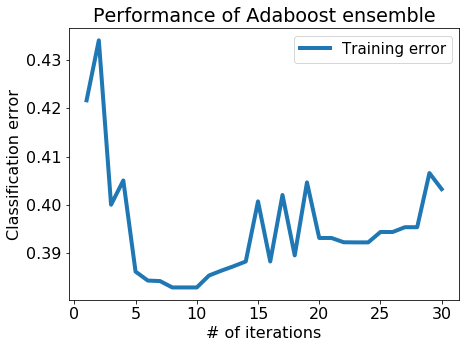

In [124]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})
plt.show()
plt.close()

**Quiz Question**: Which of the following best describes a **general trend in accuracy** as we add more and more components? Answer based on the 30 components learned so far.

1. Training error goes down monotonically, i.e. the training error reduces with each iteration but never increases.
2. Training error goes down in general, with some ups and downs in the middle.
3. Training error goes up in general, with some ups and downs in the middle.
4. Training error goes down in the beginning, achieves the best error, and then goes up sharply.
5. None of the above


### Evaluation on the test data

Performing well on the training data is cheating, so lets make sure it works on the `test_data` as well. Here, we will compute the classification error on the `test_data` at the end of each iteration.

In [120]:
test_data.shape

(9284, 25)

In [121]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0-np.sum(test_data[target]==predictions)/len(predictions)
    test_error_all.append(error)
    print ("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.42330891857
Iteration 2, test error = 0.429125376993
Iteration 3, test error = 0.398104265403
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.379577768203
Iteration 6, test error = 0.378823782852
Iteration 7, test error = 0.378931495045
Iteration 8, test error = 0.377638948729
Iteration 9, test error = 0.377638948729
Iteration 10, test error = 0.377638948729
Iteration 11, test error = 0.381732012064
Iteration 12, test error = 0.381301163292
Iteration 13, test error = 0.384747953468
Iteration 14, test error = 0.384317104696
Iteration 15, test error = 0.400473933649
Iteration 16, test error = 0.383670831538
Iteration 17, test error = 0.405320982335
Iteration 18, test error = 0.384317104696
Iteration 19, test error = 0.408013787161
Iteration 20, test error = 0.38981042654
Iteration 21, test error = 0.38981042654
Iteration 22, test error = 0.387763894873
Iteration 23, test error = 0.387763894873
Iteration 24, test error = 0.387763894873
Iter

### Visualize both the training and test errors

Now, let us plot the training & test error with the number of iterations.

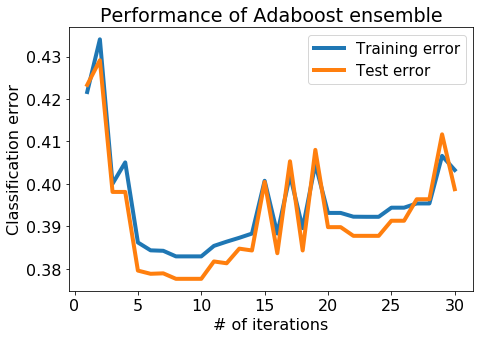

In [125]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()
plt.show()
plt.close()

** Quiz Question:** From this plot (with 30 trees), is there massive overfitting as the # of iterations increases?

In [128]:
print('Answer:no')

Answer:no
